# 2D Seismic Refraction Modeling and Inversion with PyGIMLi

This notebook demonstrates how to perform synthetic modeling and inversion for a 2D seismic refraction survey using `pyGIMLi`.  The example is taken from [here](https://www.pygimli.org/_examples_auto/2_seismics/plot_01_refraction_manager.html)

**Author:** Alberto Carrera

We start by importing the necessary packages:

In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt # mesh creation and visualization
import pygimli.physics.traveltime as tt #simulating and inverting seismic travel-time data.

## Example 1
We construct a three-layered sloping model. Each layer is represented as a closed polygon with a unique marker. Markers will later allow us to assign different velocities to each layer.  
After defining the geometry, we generate a triangular mesh with controlled cell quality and size, which will be used for both simulation and visualization.

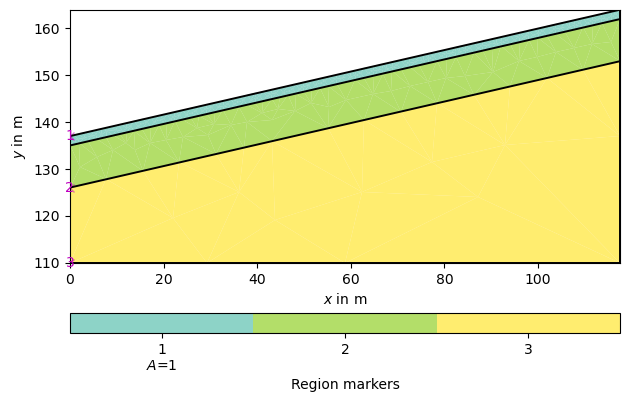

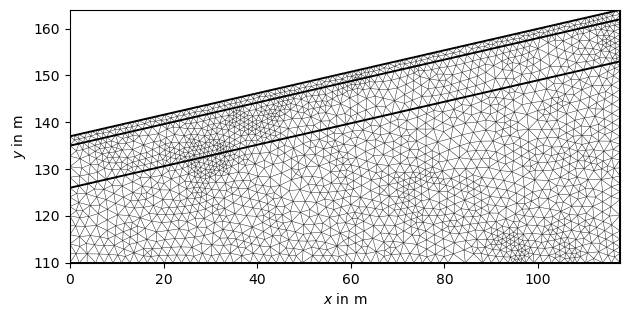

In [2]:
layer1 = mt.createPolygon([[0.0, 137], [117.5, 164], [117.5, 162], [0.0, 135]],
                          isClosed=True, marker=1, area=1)
layer2 = mt.createPolygon([[0.0, 126], [0.0, 135], [117.5, 162], [117.5, 153]],
                          isClosed=True, marker=2)
layer3 = mt.createPolygon([[0.0, 110], [0.0, 126], [117.5, 153], [117.5, 110]],
                          isClosed=True, marker=3)

geom = layer1 + layer2 + layer3

# If you want no sloping flat earth geometry .. comment out the next 3 lines
# geom = mt.createWorld(start=[0.0, 110], end=[117.5, 137],
#                       layers=[137-2, 137-11])
# slope = 0.0

pg.show(geom)

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
ax, _ = pg.show(mesh)

Next, we define geophone positions along the surface. We specify the number of geophones and linearly space them along the horizontal axis.  
We define a measurement scheme (`RAData`), which consists of shot and receiver indices.

In [3]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = tt.createRAData(sensors, shotDistance=3)

# Adapt sensor positions to slope
slope = (164 - 137) / 117.5
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 137
    pos[i, 1] = new_y

scheme.setSensors(pos)
scheme

Data: Sensors: 48 data: 752, nonzero entries: ['g', 's', 'valid']

### 1.1 Synthetic data generation
Now we initialize the  `TravelTimeManager` and asssign P-wave velocities to the layers.  
To this end, we create a map from cell markers 0 through 3 to velocities (in m/s) and generate a velocity vector. To check whether the model looks correct, we plot it along with the sensor positions.



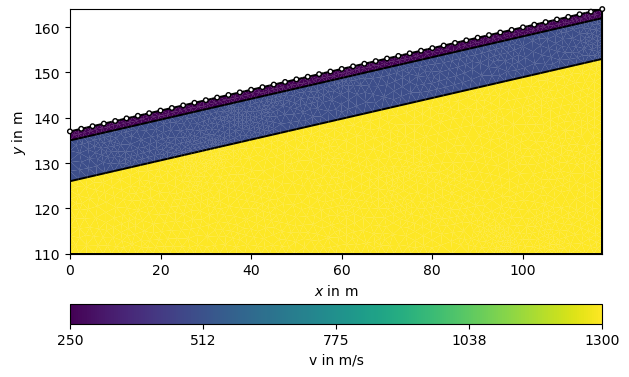

In [4]:
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 250
vp[vp == 2] = 500
vp[vp == 3] = 1300

ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

We use this model to create noisified synthetic data and look at the traveltime data matrix.  
We pass the slowness (1/velocity) of each cell, the measurement scheme, and the mesh.  
Small random noise is added to make the synthetic data more realistic.

07/10/25 - 12:15:32 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.008790995543598544 0.14101993727141837


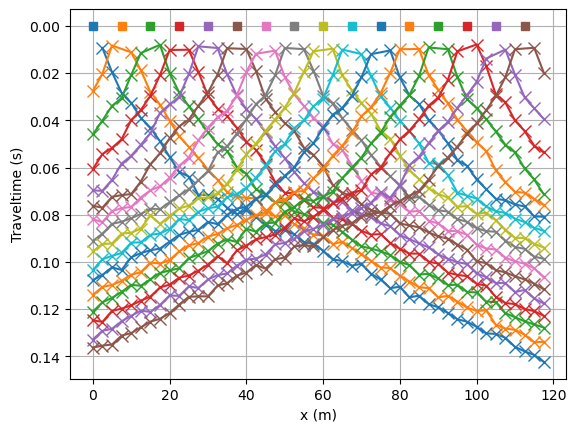

In [5]:
data = tt.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                   noiseLevel=0.001, noiseAbs=0.001, seed=1337, verbose=True)
tt.show(data)

### 1.2 Inversion
Now we invert the synthetic data. We need a new independent mesh without information about the layered structure. This mesh can be created manual or automatically guessed from the data sensor positions (in this example).  
`secNodes` controls angular resolution for ray tracing, `paraMaxCellSize` defines maximum cell size in the parametric domain (tuned at 15m²), `maxIter` sets the number of iterations.

The inversion minimizes the difference between measured (synthetic) and predicted travel times.
After inversion, we check the chi-squared misfit to ensure the solution is consistent with the synthetic data.

In [6]:
mgr = tt.TravelTimeManager(data)
vest = mgr.invert(secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more than one boundary defined.2
Boundary 0x609adea3e440 rtti: 22 id: 0	N: 0 1  marker: 1 
Boundary 0x609ae63242d0 rtti: 22 id: 96	N: 4 0  marker: -1 
07/10/25 - 12:15:34 - pyGIMLi - INFO - Found 1 regions.
07/10/25 - 12:15:34 - pyGIMLi - INFO - Found 1 regions.
07/10/25 - 12:15:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/10/25 - 12:15:34 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
07/10/25 - 12:15:34 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
07/10/25 - 12:15:34 - pyGIMLi - INFO - Created startmodel from forward operator:1198, min/max=0.000200/0.002000
07/10/25 - 12:15:34 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 97
  Input segments: 98
  Input holes: 0

  Mesh vertices: 675
  Mesh triangles: 1198
  Mesh edges: 1872
  Mesh exterior boundary edges: 150
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 150

min/max(dweight) = 876.409/991.286
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7aaee0c62f70>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.0079/0.14
min/max (error): 0.8%/12.81%
min/max (start

The manager also holds the method `showResult()` that is used to plot the result.
Note that only covered cells are shown by default.
For comparison, we plot the geometry on top.

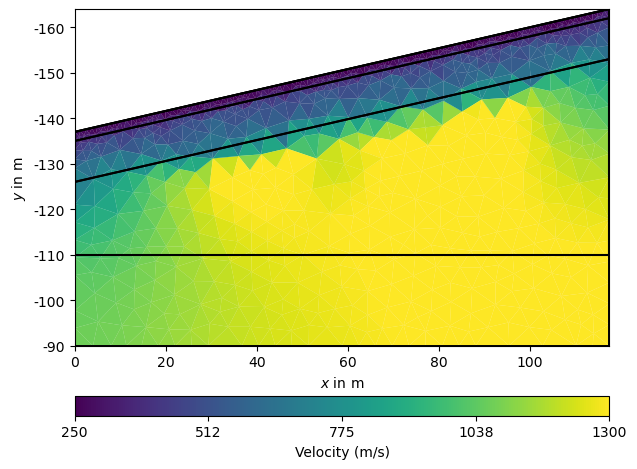

In [7]:
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), logScale=False)
ax, _ = pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

Finally, we inspect the fit between synthetic travel times and predicted travel times. This helps us verify the inversion accuracy and check for potential inconsistencies.  
PyGIMLi provides quantitative measures of how well the computed (modeled) travel times fit the observed (measured) ones:

- **Chi-squared (χ²)** – measures the *normalized misfit* between observed and predicted data.  
  $$
  \chi^2 = \frac{1}{N} \sum_i \left( \frac{t_i^{\text{obs}} - t_i^{\text{calc}}}{\sigma_i} \right)^2
  $$
  where $ t_i^{\text{obs}} $ are the observed times, $ t_i^{\text{calc}} $ are the calculated times, and $ \sigma_i $ are the data errors.  
  - Ideally, χ² ≈ 1 means the model fits the data within the expected noise level 
  - χ² >> 1 suggests underfitting  
  - χ² << 1 may indicate overfitting or overestimated data errors

- **Relative RMS error (RMS%)** – expresses the *average relative deviation* between observed and calculated data, as a percentage.  
  $$
  \text{RMS}_{\text{rel}} = 100 \times \sqrt{ \frac{1}{N} \sum_i \left( \frac{t_i^{\text{obs}} - t_i^{\text{calc}}}{t_i^{\text{obs}}} \right)^2 }
  $$
  A smaller RMS (typically < 5 %) indicates a good overall fit.

χ² : 0.911
RMS_rel (%): 2.10


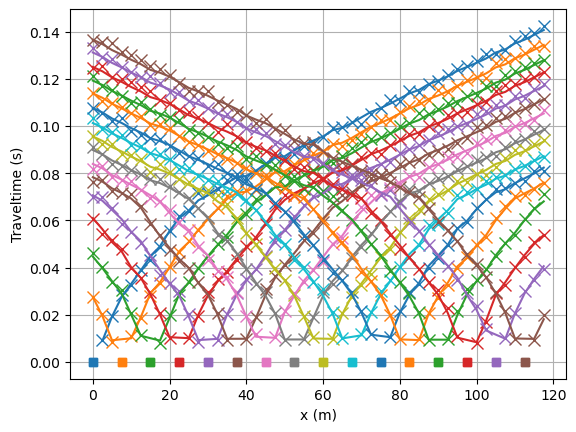

In [8]:
# Show data fit visually and print numerical misfit values
mgr.showFit(firstPicks=True)
print(f"χ² : {mgr.inv.inv.chi2():.3f}")
print(f"RMS_rel (%): {mgr.inv.inv.relrms():.2f}")

## Example 2
Taken from [here](https://github.com/halbmy/GeophysicalMethods/blob/main/notebooks/16RefractionModelling.ipynb), in a nutshell:

1. Specify geophone positions and measurement scheme.
2. Create a triangular mesh for numerical calculations. 
3. Define a subsurface geometry.
4. Assign velocities and visualize the model.
5. Simulate synthetic travel-time data.
6. Invert the data to recover velocities.
7. Visualize results and compare with the original model.
8. Inspect the data fit for quality control.

In [9]:
data = tt.createRAData(np.arange(41)*2, shotDistance=5)
print(data)

Data: Sensors: 41 data: 360, nonzero entries: ['g', 's', 'valid']


(<Axes: xlabel='$x$ in m', ylabel='$y$ in m'>, None)

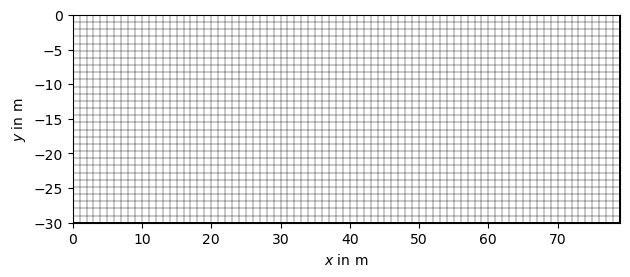

In [10]:
grid = mt.createGrid(np.arange(min(pg.x(data)), max(pg.x(data)), step=1, dtype=float), np.linspace(-30, 0, 30))
pg.show(grid)

(<Axes: xlabel='$x$ in m', ylabel='$y$ in m'>,
 <matplotlib.colorbar.Colorbar at 0x7aaed6b69e90>)

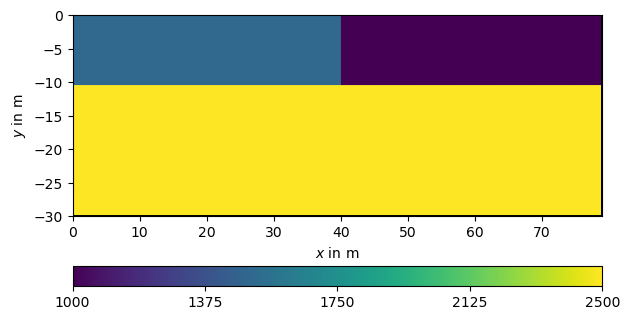

In [11]:
cx = pg.x(grid.cellCenters())
cy = pg.y(grid.cellCenters())
velLayers = np.ones(grid.cellCount()) * 1000
velLayers[cy < -10] = 2500
velLayers[(cy >= -10) & (cx < 40)] = 1500
pg.show(grid, velLayers)

07/10/25 - 12:15:41 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


<Axes: xlabel='x (m)', ylabel='Traveltime (s)'>

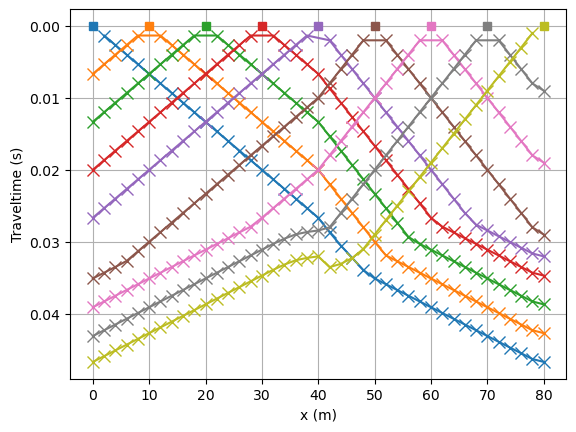

In [12]:
dataLayers = tt.simulate(mesh=grid, scheme=data, vel=velLayers)
fig, ax = pg.plt.subplots()
tt.drawFirstPicks(ax, dataLayers)

In [13]:
mgr = tt.TravelTimeManager(dataLayers)
mgr.invert(paraDX=0.25, lam=300, zWeight=0.2, verbose=True)

07/10/25 - 12:15:43 - pyGIMLi - INFO - Found 1 regions.
./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more than one boundary defined.2
Boundary 0x609ae28a8e80 rtti: 22 id: 122	N: 4 0  marker: -1 
Boundary 0x609ae28bfa50 rtti: 22 id: 0	N: 0 1  marker: 1 
07/10/25 - 12:15:43 - pyGIMLi - INFO - Found 1 regions.
07/10/25 - 12:15:43 - pyGIMLi - ERROR - <class 'pygimli.physics.traveltime.TravelTimeManager.TravelTimeManager'>.checkError(TravelTimeManager.py:98)
DataContainer has no "err" values. Fallback to 3%
07/10/25 - 12:15:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/10/25 - 12:15:43 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
07/10/25 - 12:15:43 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
07/10/25 - 12:15:43 - pyGIMLi - INFO - Created startmodel from forward operator:797, min/max=0.000200/0.002000
07/10/25 - 12:15:43 - 

Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 123
  Input segments: 124
  Input holes: 0

  Mesh vertices: 473
  Mesh triangles: 797
  Mesh edges: 1269
  Mesh exterior boundary edges: 147
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 147

min/max(dweight) = 713.73/33333.3
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7aaed6a689a0>
Data transformation: Identity transform
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1

797 [1561.9823531073398,...,2211.734218697293]

Performing line search with tau = 1
3: Model: min = 0.000409452; max = 0.00132661
3: Response: min = 0.00103599; max = 0.0471859
3: rms/rrms(data, Response) = 0.000816496/2.93346%
3: chi^2(data, Response, error, log) = 0.95613
3: Phi = 344.207+0.328486*300=442.753


(-24.0, 0.0)

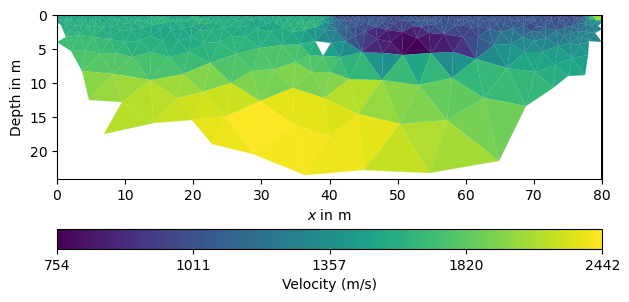

In [14]:
ax, cbar = mgr.showResult(logScale=True,
                          coverage=mgr.standardizedCoverage())
ax.set_ylim(-24, 0)
## mgr.coverage() yields the ray coverage in m and standardizedCoverage as 0/1

χ² : 0.956
RMS_rel (%): 2.93


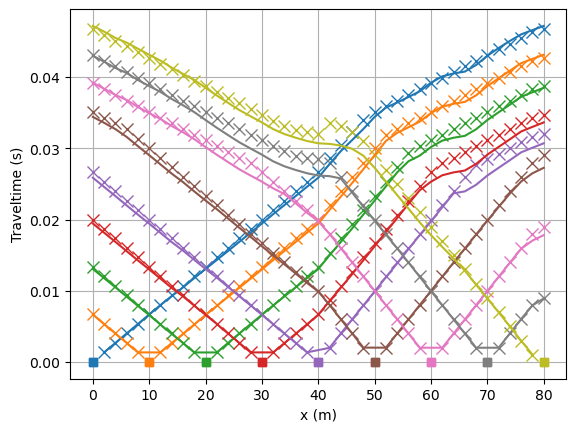

In [15]:
mgr.showFit(firstPicks=True)
print(f"χ² : {mgr.inv.inv.chi2():.3f}")
print(f"RMS_rel (%): {mgr.inv.inv.relrms():.2f}")